In [7]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import addict
import datetime
import os
import pickle
import scipy
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import skies


# Read in mesh file and create output folder

In [9]:
# mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
# mesh_parameters_file_name = "western_north_america_mesh_parameters_dense.json"
mesh_parameters_file_name = "nankai_mesh_parameters.json"
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)


output_path='./runs/2022_10_15_22_03_52'
Read: nankai_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: nankai.msh
Magnitude overview:
Maximum moment magnitude of entire mesh = 9.94
Maximum moment magnitude of single mesh element = 6.56
Minimum moment magnitude of single mesh element = 5.20


# Mesh geometry and estimated slip deficit rate
- Mesh geometry
- Mesh element areas
- Mesh slip deficit rates (from `celeri`)

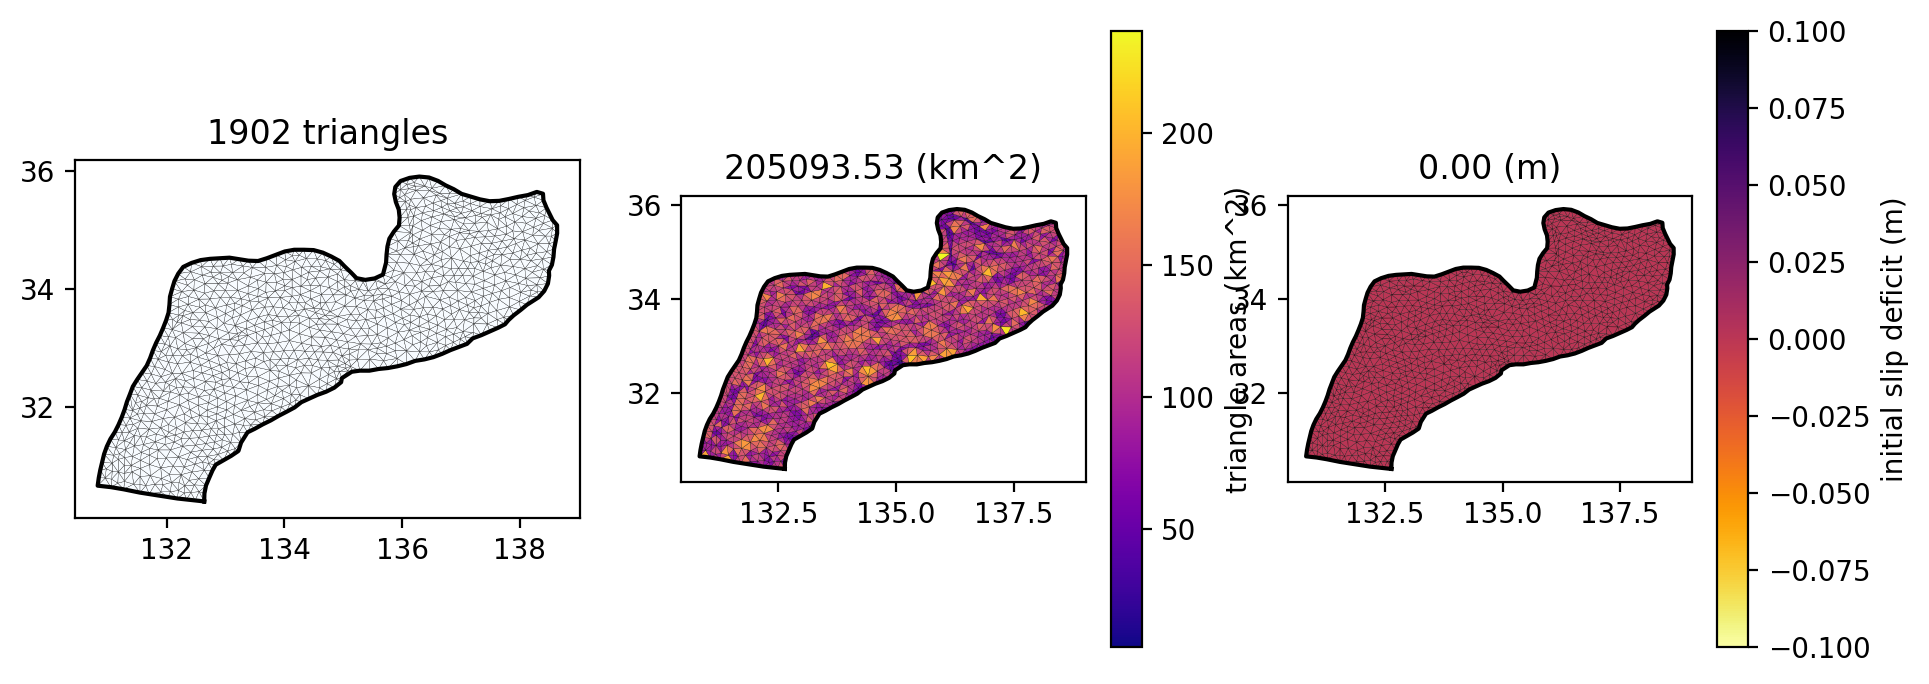

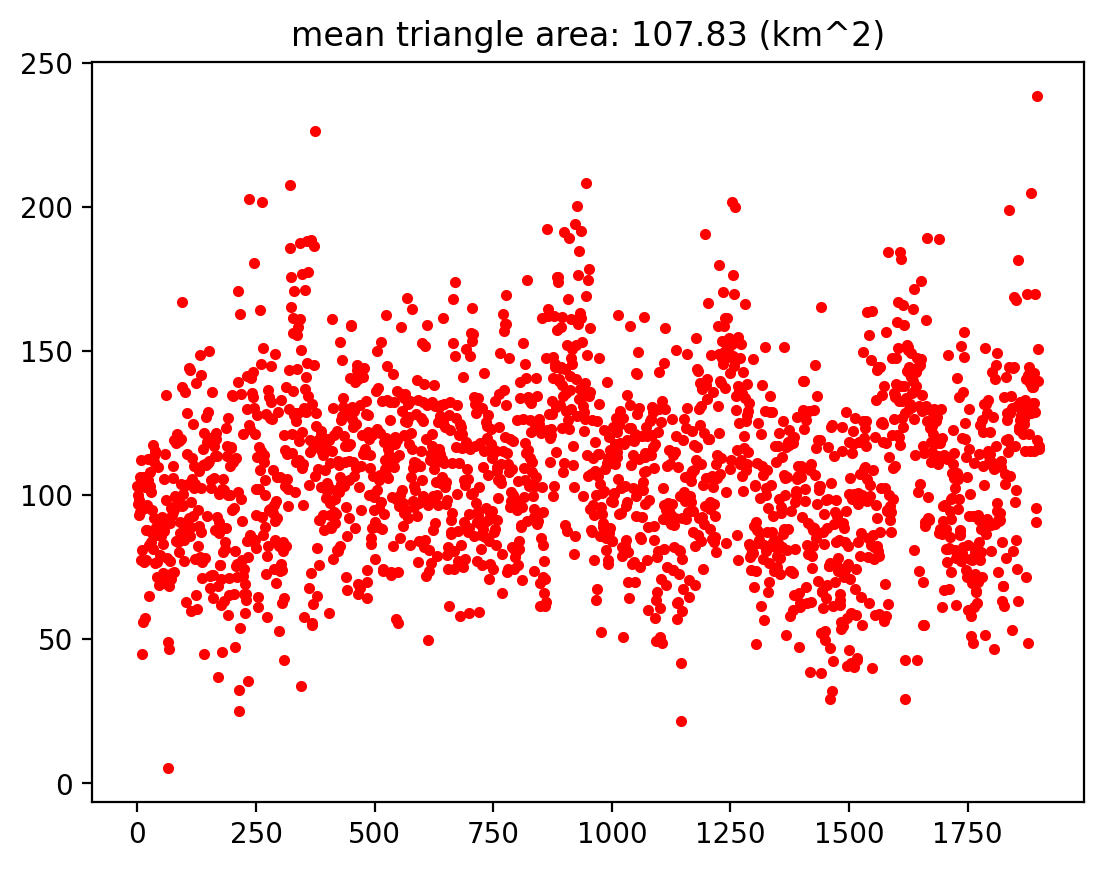

In [10]:
initial_slip_deficit = np.zeros(meshes[0].n_tde)
skies.plot_initial_data(meshes, initial_slip_deficit)

plt.figure()
plt.plot(meshes[0].areas / 1e6, "r.")
plt.title(f"mean triangle area: {np.mean(meshes[0].areas / 1e6):0.2f} (km^2)")
plt.show()


i=0


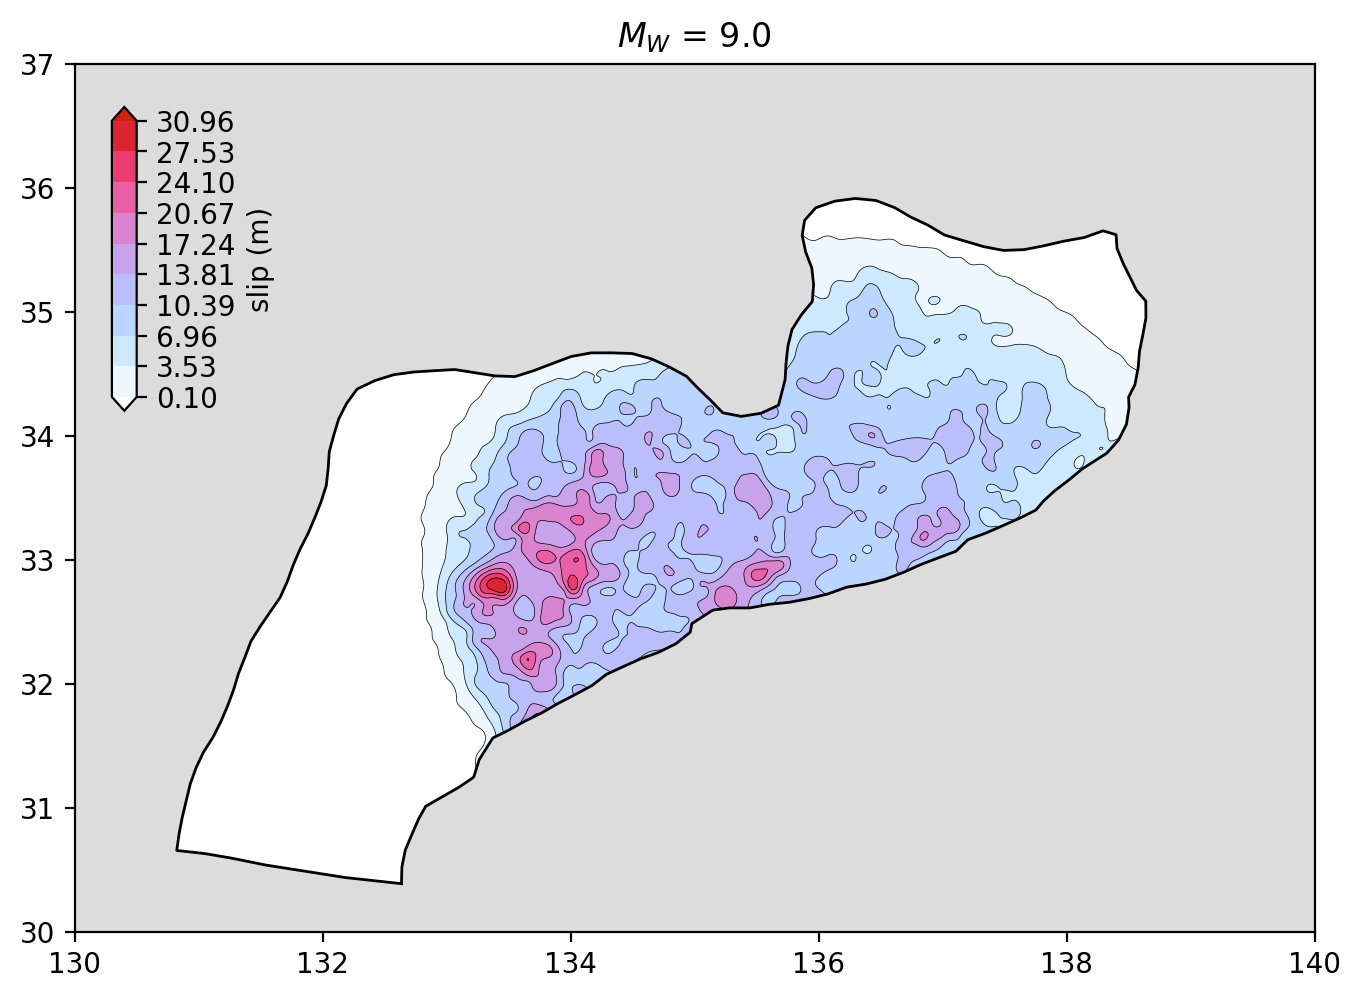

In [13]:
# Run and plotting parameters
params = addict.Dict()
params.n_grid_longitude = 5000
params.n_grid_latitude = 5000
params.min_longitude = 130.0
params.max_longitude = 140.0
params.min_latitude = 30.0
params.max_latitude = 37.0
params.n_contour_levels = 10
params.min_contour_value = 0.1  # (m)
params.savefig = True
params.run_name = run_name

# Event parameters
event = addict.Dict()
event.hypocenter_longitude = 136.0  #  (degrees)
event.hypocenter_latitude = 33.0  #  (degrees)
event.hypocenter_depth = -15.0  # (km)
event.shear_modulus = 3e10  #  (Pa)
event.area_scaling = 1.25

# example_moment_magnitudes = [6.0, 7.0, 8.0, 9.0]
example_moment_magnitudes = [9.0]
for i in range(len(example_moment_magnitudes)):
    print(f"{i=}")

    # Create synthetic event
    event.moment_magnitude = example_moment_magnitudes[i]
    event = skies.get_event_area_slip_hypocenter(meshes[0], event)

    # Plot event eigenmodes
    # skies.plot_event_select_eigenmodes(meshes[0], event, params)

    # Plot event slip
    skies.quick_plot_slip(meshes[0], event, params)


interp2d elapsed time: 1.1962291250238195
inpolygon elapsed time: 10.459626875002868



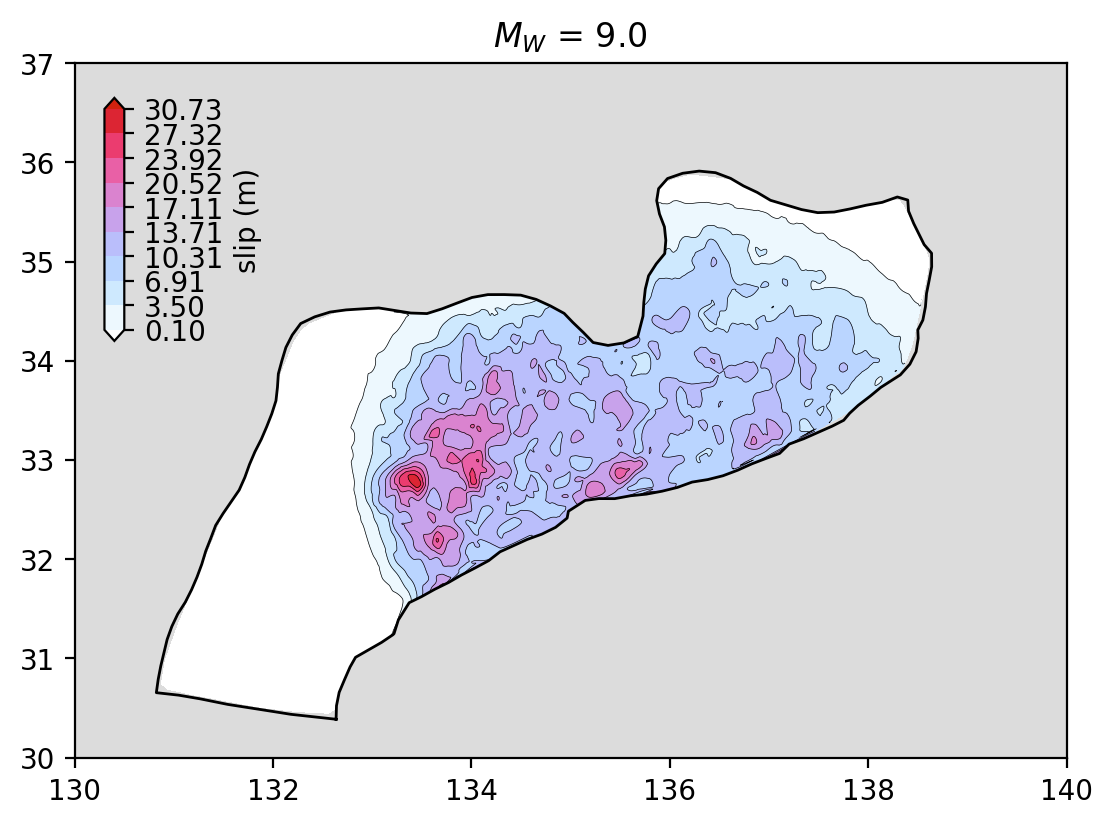

In [38]:
import timeit
# TODO Interpolation experiments
# RBF interploation looks great but it is very very slow
#    Low res Nankai plot with 5000x5000 observation points takes 3 min 18 seconds
#
# Can we do better?  Some references:
# https://plotly.com/python/v3/interpolation-and-extrapolation-in-2d/
# https://github.com/GlacioHack/xdem/pull/165
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d

# Nearest neighbor griddata
fill_value = event.slip_all_elements
x_vec = np.linspace(params.min_longitude, params.max_longitude, params.n_grid_longitude)
y_vec = np.linspace(params.min_latitude, params.max_latitude, params.n_grid_latitude)
x_mat, y_mat = np.meshgrid(x_vec, y_vec)
centroids_lon = meshes[0].centroids[:, 0]
centroids_lat = meshes[0].centroids[:, 1]
centroids_val = fill_value

from scipy.interpolate import griddata

start_time = timeit.default_timer()
fill_value_mat = griddata(
    (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
)
print(f"interp2d elapsed time: {timeit.default_timer() - start_time}")


# Select only values inside of mesh polygon
start_time = timeit.default_timer()
inpolygon_vals = skies.inpolygon(
    x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(
    inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
)
fill_value_mat[~inpolygon_vals] = np.nan
print(f"inpolygon elapsed time: {timeit.default_timer() - start_time}")
print()


# Plot
cmap = cc.cm.CET_L19
levels = np.linspace(
    params.min_contour_value, np.nanmax(fill_value_mat), params.n_contour_levels
)
plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
cb = plt.colorbar(cax=plt.gca().inset_axes((0.03, 0.60, 0.02, 0.35)), label="slip (m)")
plt.contour(
    x_mat,
    y_mat,
    fill_value_mat,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().set_facecolor("gainsboro")
plt.title(f"$M_W$ = {event.moment_magnitude:0.3}")
plt.show()


# x = np.arange(-5.0, 5.0, 0.25)
# y = np.arange(-5.0, 5.0, 0.25)
# xx, yy = np.meshgrid(x, y)
# z = np.sin(xx**2+yy**2)
# import timeit
# start_time = timeit.default_timer()
# interpolate_object = scipy.interpolate.interp2d(
#     centroids_lon, centroids_lat, fill_value, kind="cubic"
# )
# fill_value_mat = interpolate_object(x_vec, y_vec)
# elapsed_time = timeit.default_timer() - start_time
# print(f"interp2d: {elapsed_time=}")

# TODO: Faster inpolygon
# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
# https://github.com/dengwirda/inpoly-python


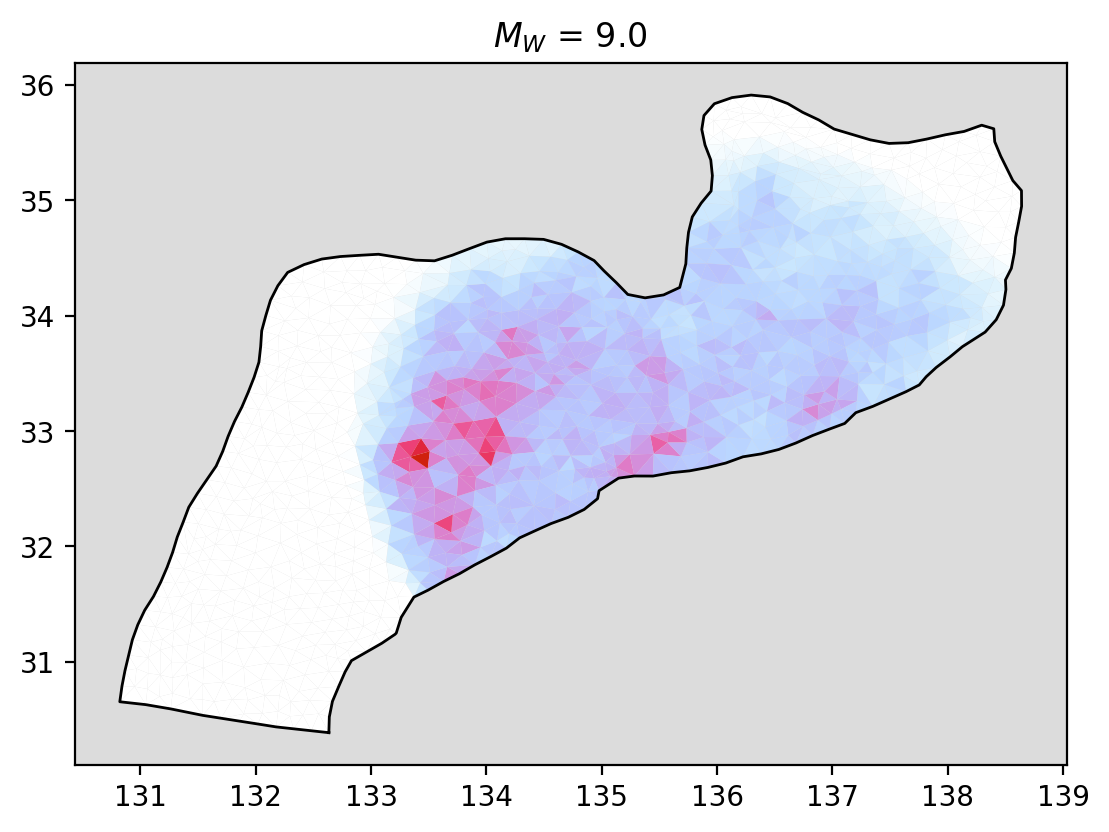

In [27]:
import matplotlib
# Old school poly collection
x_coords = meshes[0].meshio_object.points[:, 0]
y_coords = meshes[0].meshio_object.points[:, 1]
vertex_array = np.asarray(meshes[0].verts)

ax = plt.gca()
xy = np.c_[x_coords, y_coords]
verts = xy[vertex_array]
pc = matplotlib.collections.PolyCollection(
    verts,
    edgecolor="k",
    cmap=cmap,
    linewidth=0.0,
    alpha=1.0,
)
pc.set_array(fill_value)
ax.add_collection(pc)
ax.autoscale()
plt.gca().set_aspect("equal")

plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().set_facecolor("gainsboro")
plt.title(f"$M_W$ = {event.moment_magnitude:0.3}")
plt.show()


In [23]:
fill_value_mat.shape

(5000, 5000)

# Gutenberg-Richter style earthquake frequency distribution

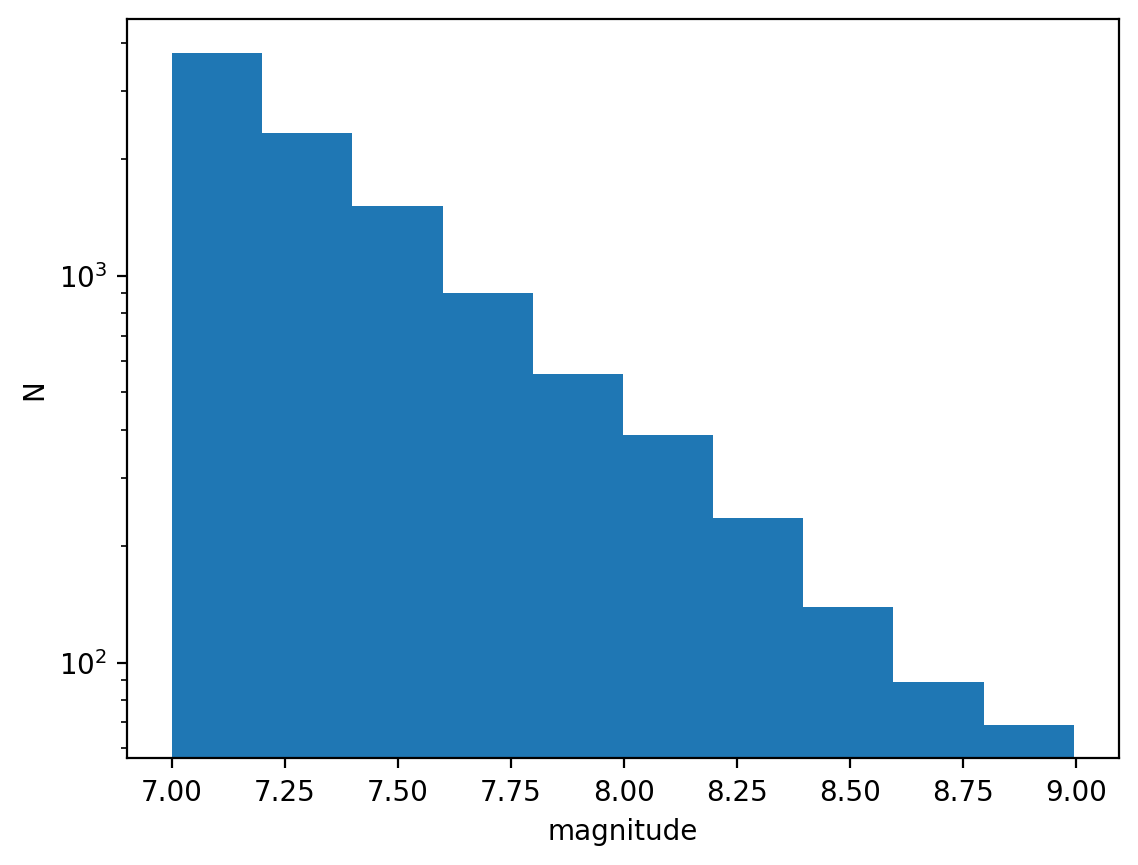

In [12]:
b_value = -1.0
minimum_event_moment_magnitude = 7.0
maximum_event_moment_magnitude = 9.0
n_events = 10000
magnitudes = np.zeros(n_events)
for i in range(n_events):
    magnitudes[i] = skies.get_gutenberg_richter_magnitude(
        b_value, minimum_event_moment_magnitude, maximum_event_moment_magnitude
    )

plt.figure()
plt.hist(magnitudes, log=True)
plt.xlabel("magnitude")
plt.ylabel("N")
plt.show()
